In [1]:
from datascience import *
from urllib.request import urlopen
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", palette="Set2")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("MSK_2018")
df = df.drop([1,2,3])

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (6,7,8,35,37,50,51,52,53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#manually creating the molecular subtypes https://www.breastcancer.org/types/molecular-subtypes
#https://www.mayoclinic.org/diseases-conditions/breast-cancer/in-depth/breast-cancer/art-20045654#:~:text=This%20group%20includes%20tumors%20that,PR%20negative%20and%20HER2%20positive.
#https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/breast-cancer-hormone-receptor-status.html
    #LUMA - ER+ PR+ HER2- (HR+/HER2-)
    #LUMB - ER+ PR- HER2- (either hihg levels of Ki-67 or PR-) (HR+/HER2-)
    #LUMB-like ER+ HER2+ (any levels of Ki-67 or PR+/-) (HR+/HER2+)
    #HER2-enrinched - ER- PR- HER2+ (HR-/HER2+)
    #Triple-negative - ER- PR- HER2- (HR-/HER2-)
#ER Status of the Primary Tumor: column 15
#PR Status of the Primary Tumor: column 17
#Overall HER2 Status of Sequenced Sample: column 26
#Receptor Status Primary: column 14

def pr_tester(row, subtypes): 
    #it check for pr because that the defining difference and I do this check multiple times
    #HR+/HER2-
    if row[1]['PR Status of the Primary'] == "Negative":
            subtypes.append("Luminal B")
    elif row[1]['PR Status of the Primary'] == "Positive":
        subtypes.append("Luminal A")
    elif row[1]['PR Status of Sequenced Sample'] == "Positive":
        subtypes.append("Luminal A")
    elif row[1]['PR Status of Sequenced Sample'] == "Negative":
        subtypes.append("Luminal B")
    else:
        subtypes.append("No PR")

subtypes = []
for row in df.iterrows():
    if row[1]['Receptor Status Primary'] == "HR+/HER2+":
        subtypes.append("Luminal B-like")
    elif row[1]['Receptor Status Primary'] == "HR-/HER2-" or row[1]['Receptor Status Primary'] == "Triple Negative":
        subtypes.append("Triple Negative")
    elif row[1]['Receptor Status Primary'] == "HR+/HER2-":
        pr_tester(row, subtypes)
    elif row[1]['Receptor Status Primary'] == 'HR-/HER2+':
        subtypes.append("HER2-Enrinched")
    elif row[1]['Receptor Status Primary'] == 'HR+/HER2_Equivocal':
        if row[1]['HER2 FISH Status (Report and ASCO) of Primary'] == 'Negative':
            #HR+/HER2-
            pr_tester(row, subtypes)
        elif row[1]['HER2 FISH Status (Report and ASCO) of Primary'] == 'Positive':
            #HR+/HER2+
            subtypes.append("Luminal B-like")
        else:
            subtypes.append("No HER2")
    elif row[1]['Receptor Status Primary'] == 'HR-/HER2_Equivocal':
        if row[1]['HER2 FISH Status (Report and ASCO) of Primary'] == 'Negative':
            #HR-/HER2-
            subtypes.append("Triple Negative")
        elif row[1]['HER2 FISH Status (Report and ASCO) of Primary'] == 'Positive':
            #HR-/HER2+
            subtypes.append("HER2-Enrinched")
        else:
            subtypes.append("No HER2")
    elif row[1]['Receptor Status Primary'] == 'HR+/HER2_Unknown':
        #HR+/HER2+
        if row[1]["Overall HR Status of Sequenced Sample"] == "Positive":
            subtypes.append("Luminal B-like")
        #HR+/HER2-
        elif row[1]["Overall HR Status of Sequenced Sample"] == "Negative":
            pr_tester(row, subtypes)
        else:
            subtypes.append("No HER2")
        
    elif row[1]['Receptor Status Primary'] == 'HR-/HER2_Unknown':
        #HR-/HER2+
        if row[1]["Overall HR Status of Sequenced Sample"] == "Positive":
            subtypes.append("HER2-Enrinched")
        #HR-/HER2-
        elif row[1]["Overall HR Status of Sequenced Sample"] == "Negative":
            subtypes.append("Triple Negative")
        else:
            subtypes.append("No HER2")
    elif row[1]['Receptor Status Primary']  == 'Receptor Status of the Primary Tumor':
        subtypes.append("None")
    else:
        if row[1]['Overall HR Status of Sequenced Sample'] == "Positive":
            #HR+
            #HR+/HER2+
            if row[1]["Overall HER2 Status of Sequenced Sample"] == "Positive":
                subtypes.append("Luminal B-like")
            #HR+/HER2-
            elif row[1]["Overall HER2 Status of Sequenced Sample"] == "Negative":
                pr_tester(row, subtypes)
            else:
                subtypes.append("No HER2")
        elif row[1]['Overall HR Status of Sequenced Sample'] == "Negative":
            #HR-
            #HR-/HER2+
            if row[1]["Overall HER2 Status of Sequenced Sample"] == "Positive":
                subtypes.append("HER2-Enrinched")
            #HR-/HER2-
            elif row[1]["Overall HER2 Status of Sequenced Sample"] == "Negative":
                subtypes.append("Triple Negative")
            else:
                subtypes.append("No HER2")
df["Subtype"] = subtypes  

In [4]:
list = []
for row in df.iterrows():
    if row[1]["Overall Survival Status"] == '0:LIVING':
        list.append(0)
    else:
        list.append(1)
df["Overall Survival Status"] = list

In [6]:
df.to_csv("subtyped_data")

In [5]:
df.groupby(["Hugo_Symbol"]).count().sort_values("Unnamed: 0", ascending = False)

,Unnamed: 0,#Patient Identifier,Sample Identifier,Sample Type,Site of Sample,Prior Breast Primary,Time to Diagnosis Invasive Carcinoma,NGS Sample Collection Time Period,Invasive Carcinoma Diagnosis Age,Tumor Tissue Origin,Tumor Sample Histology,Overall Primary Tumor Grade,Primary Nuclear Grade,Stage At Diagnosis,Receptor Status Primary,ER Status of the Primary,ER PCT Primary,PR Status of the Primary,PR PCT Primary,HER2 IHC Status Primary,HER2 IHC Score Primary,HER2 FISH Status (Report and ASCO) of Primary,HER2 FISH Ratio Primary,Overall HR Status of Sequenced Sample,ER Status of Sequenced Sample,PR Status of Sequenced Sample,Overall HER2 Status of Sequenced Sample,HER2 IHC Status of Sequenced Sample,HER2 IHC Score of Sequenced Sample,HER2 FISH Status of Sequenced Sample,HER2 FISH Ratio Value of Sequenced Sample,Oncotree Code,Cancer Type,Cancer Type Detailed,Somatic Status,TMB (nonsynonymous),Metastatic Disease at Last Follow-up,Metastatic Recurrence Time,Prior Local Recurrence,Sex,Menopausal Status At Diagnosis,Primary Tumor Laterality,T Stage,N Stage,M Stage,Overall Patient Receptor Status,Overall Patient HR Status,Overall Patient HER2 Status,HER2 Primary Status,Patient's Vital Status,Last Communication Contact,Time To Death (Months),Disease Free (Months),Disease Free Event,Overall Survival (Months),Overall Survival Status,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Mutation_Status,Score,t_ref_count,t_alt_count,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,Subtype
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PIK3CA,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,814,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,582,826,826,826,826,826,826,826,826,826,826,826,826,826,172,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826,826
TP53,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,689,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,698,550,698,698,698,698,698,698,698,698,698,698,698,698,698,226,698,698,698,698,698,696,698,698,698,698,698,698,698,698,698,698,698,697,696,698,698,698,698,698,638,698,698,698,648,638,698,698
CDH1,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,309,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,313,213,313,313,313,313,313,313,313,313,313,313,313,313,313,62,313,313,313,313,313,312,313,313,313,313,313,313,313,313,313,312,313,312,312,313,313,313,313,313,269,313,313,312,272,268,313,313
GATA3,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,295,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,228,298,298,298,298,298,298,298,298,298,298,298,298,298,41,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,298,278,298,298,0,280,278,298,298
MAP3K1,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,220,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,138,224,224,224,224,224,224,224,224,224,224,224,224,224,31,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224,209,224,224,224,213,211,224,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RRAS,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BCL2L

<AxesSubplot:xlabel='Subtype', ylabel='count'>

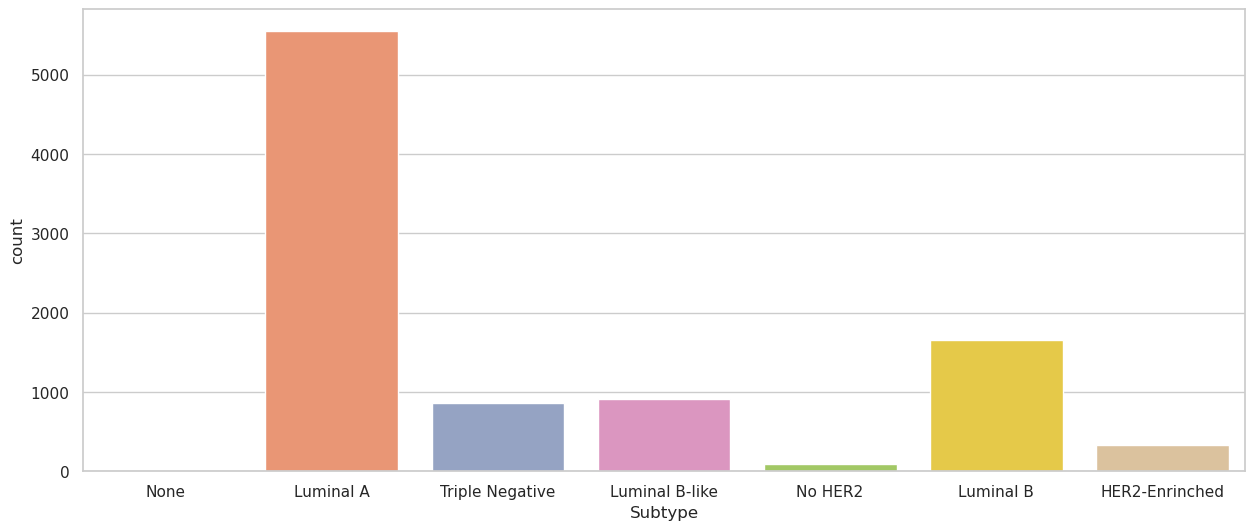

In [6]:
fig,ax = plt.subplots(figsize=(15,6))
sns.countplot(data = df, x = "Subtype")

<AxesSubplot:xlabel='Variant_Classification', ylabel='count'>

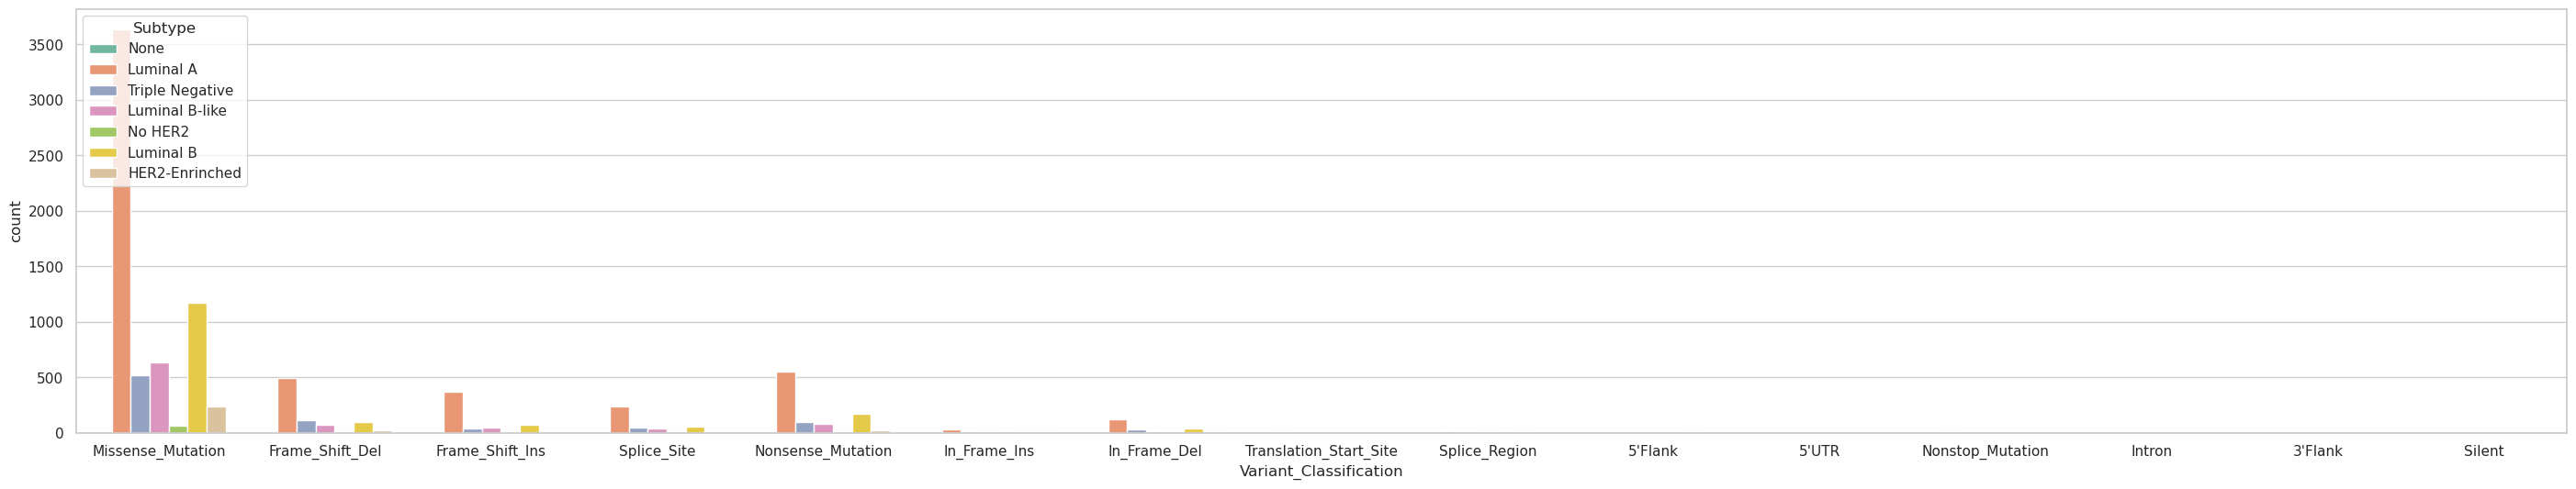

In [7]:
fig,ax = plt.subplots(figsize=(35,6))
sns.countplot(data = df, x = "Variant_Classification", hue = "Subtype")

<AxesSubplot:xlabel='Variant_Classification', ylabel='count'>

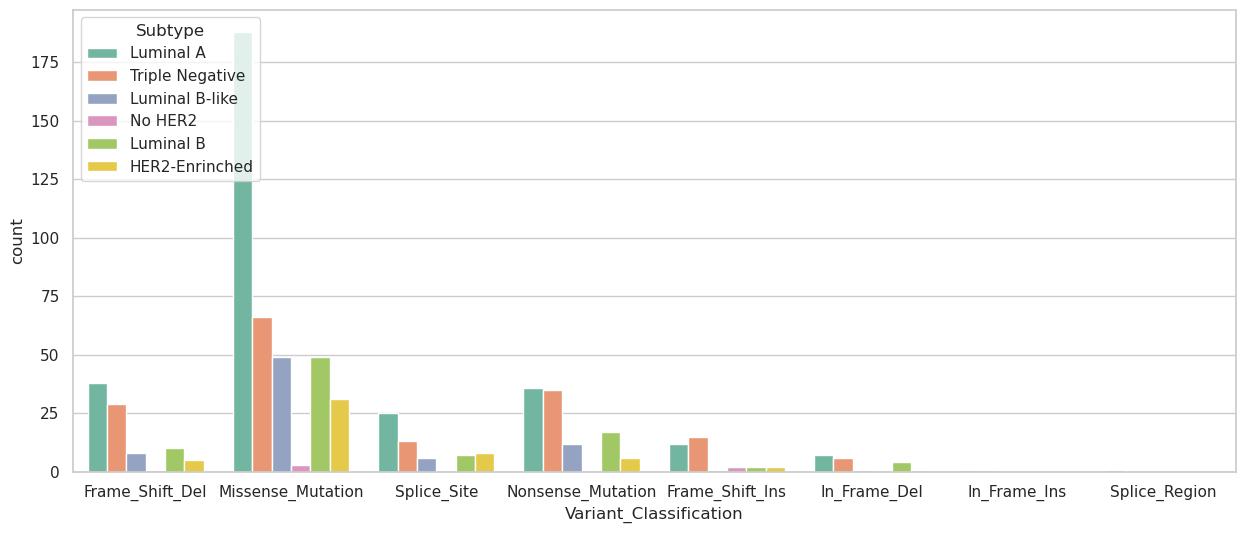

In [8]:
fig,ax = plt.subplots(figsize=(15,6))
sns.countplot(data = df.query('Hugo_Symbol == "TP53"'), x ="Variant_Classification", hue = "Subtype")

In [94]:
x = df.groupby(["Hugo_Symbol"]).count().query("`Unnamed: 0` > 5")
i = x.index
temp = df["Hugo_Symbol"] in i

TypeError: unhashable type: 'Series'

In [92]:
df

,Unnamed: 0,#Patient Identifier,Sample Identifier,Sample Type,Site of Sample,Prior Breast Primary,Time to Diagnosis Invasive Carcinoma,NGS Sample Collection Time Period,Invasive Carcinoma Diagnosis Age,Tumor Tissue Origin,Tumor Sample Histology,Overall Primary Tumor Grade,Primary Nuclear Grade,Stage At Diagnosis,Receptor Status Primary,ER Status of the Primary,ER PCT Primary,PR Status of the Primary,PR PCT Primary,HER2 IHC Status Primary,HER2 IHC Score Primary,HER2 FISH Status (Report and ASCO) of Primary,HER2 FISH Ratio Primary,Overall HR Status of Sequenced Sample,ER Status of Sequenced Sample,PR Status of Sequenced Sample,Overall HER2 Status of Sequenced Sample,HER2 IHC Status of Sequenced Sample,HER2 IHC Score of Sequenced Sample,HER2 FISH Status of Sequenced Sample,HER2 FISH Ratio Value of Sequenced Sample,Oncotree Code,Cancer Type,Cancer Type Detailed,Somatic Status,TMB (nonsynonymous),Metastatic Disease at Last Follow-up,Metastatic Recurrence Time,Prior Local Recurrence,Sex,Menopausal Status At Diagnosis,Primary Tumor Laterality,T Stage,N Stage,M Stage,Overall Patient Receptor Status,Overall Patient HR Status,Overall Patient HER2 Status,HER2 Primary Status,Patient's Vital Status,Last Communication Contact,Time To Death (Months),Disease Free (Months),Disease Free Event,Overall Survival (Months),Overall Survival Status,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Mutation_Status,Score,t_ref_count,t_alt_count,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,Subtype
0,0,#Identifier to uniquely specify a patient.,A unique sample identifier.,"The type of sample (i.e., normal, primary, met...",Sample Site,Prior Breast Primary,Time to Diagnosis Invasive Carcinoma,NGS Sample Collection Time Period,Invasive Carcinoma Diagnosis Age,Tumor Tissue of Origin of the Sequnced Tumor.,Tumor Sample Histology,Overall Primary Tumor Histological Grade.,Primary Nuclear Grade,Stage At Diagnosis,Receptor Status of the Primary Tumor,ER Status of the Primary Tumor,ER Percent Positivity of the Primary Tumor,PR Status of the Primary Tumor,PR Percent Positivity of the Primary Tumor,HER2 IHC Status of Primary Tumor,HER2 IHC Value of the Primary Tumor,HER2 FISH Status of the Primary Tumor as per P...,HER2 FISH Ratio of the Primary Tumor,Overall HR Status of the Sample that Underwent...,ER Status of the Sample that Underwent Sequenc...,PR status of the Sample that Underwent Sequenc...,Overall HER2 Status of the Sample that Underwe...,HER2 IHC Status of the Sample that Underwent S...,HER2 IHC Value of the Sample that Underwent Se...,HER2 FISH Status of the Sample that Underwent ...,HER2 FISH Ratio Value of the Sample that Under...,Oncotree Code,Cancer Type,Cancer Type Detailed,Somatic Status,TMB (nonsynonymous),Indicate metastatic disease at last followup.,Months between diagnosis of the primary tumor ...,Prior Local Recurrence,Sex,Menopausal Status At Diagnosis,"For tumors in paired organs, designates the si...",T Stage,N Stage,M Stage,Overall patient tumor receptor subtype based o...,Overall patient tumor hormone receptor status ...,Overall patient tumor HER2 status based on the...,Overall HER2 status of the primary tumor.,The survival state of the person.,Time of the last follow up in days (reference:...,Time To Death (Months),Disease free (months) since initial treatment.,Disease Free Event,Overall survival in months since initial diago...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,4,P-0000004,P-0000004-T01-IM3,Primary,Treatment Naive Primary,No,444.87,445,37,Breast,Breast Invasive Ductal Carcinoma,II Intermediate Grade (Moderately Differentia...,III (High),IV,HR+/HER2-,Positive,70,Positive,22,Negative,1+,Not Applicable,Not Applicable,Positive,Positive,Positive,Negative,Negative

<AxesSubplot:xlabel='Hugo_Symbol', ylabel='count'>

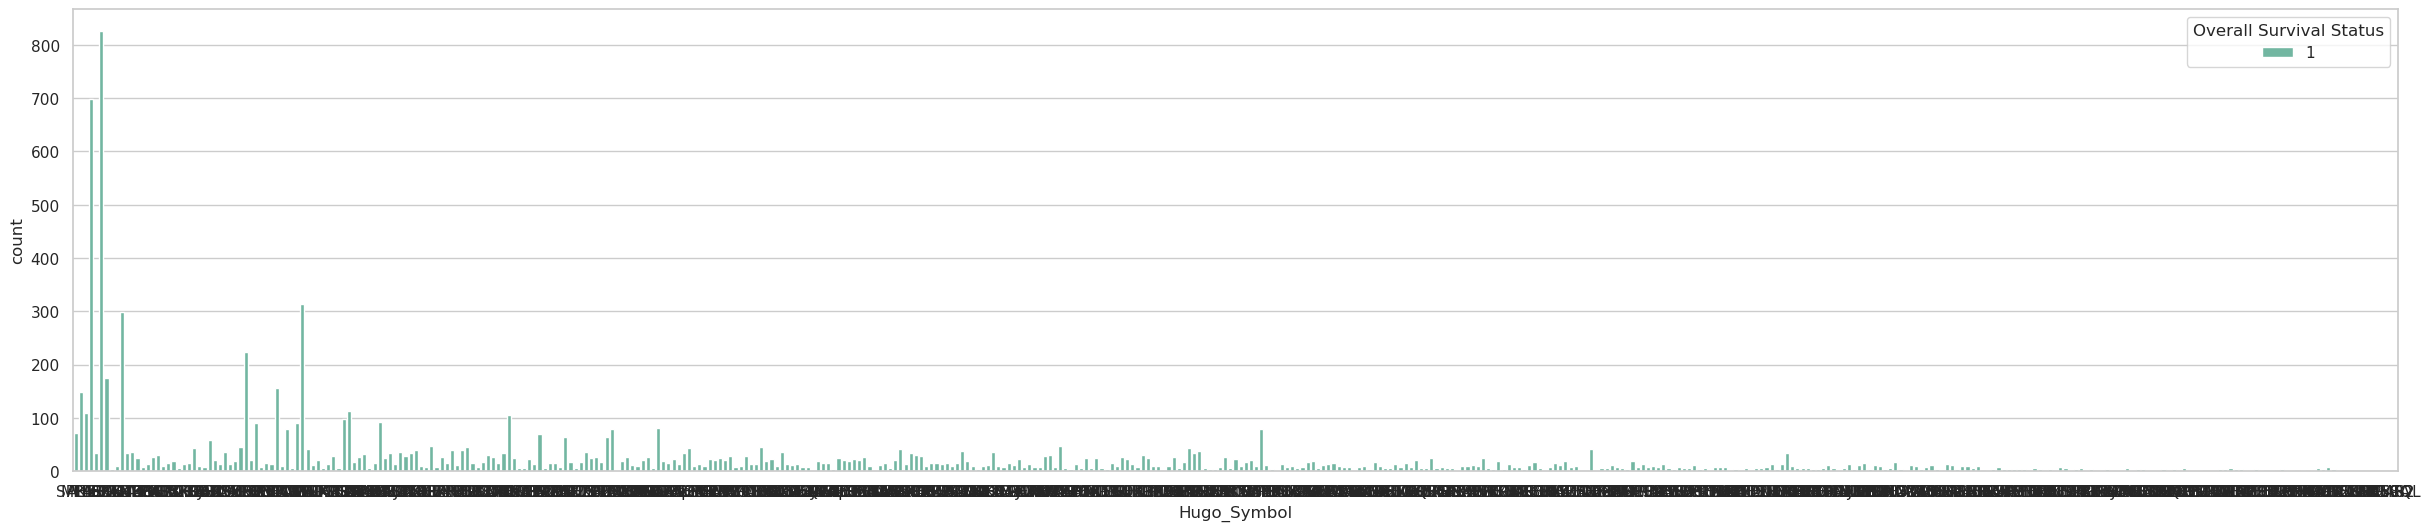

In [80]:
fig,ax = plt.subplots(figsize=(30,6))
sns.countplot(data = df, x = "Hugo_Symbol", hue = "Overall Survival Status")

In [66]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression(fit_intercept = True)


,Unnamed: 0,#Patient Identifier,Sample Identifier,Sample Type,Site of Sample,Prior Breast Primary,Time to Diagnosis Invasive Carcinoma,NGS Sample Collection Time Period,Invasive Carcinoma Diagnosis Age,Tumor Tissue Origin,Tumor Sample Histology,Overall Primary Tumor Grade,Primary Nuclear Grade,Stage At Diagnosis,Receptor Status Primary,ER Status of the Primary,ER PCT Primary,PR Status of the Primary,PR PCT Primary,HER2 IHC Status Primary,HER2 IHC Score Primary,HER2 FISH Status (Report and ASCO) of Primary,HER2 FISH Ratio Primary,Overall HR Status of Sequenced Sample,ER Status of Sequenced Sample,PR Status of Sequenced Sample,Overall HER2 Status of Sequenced Sample,HER2 IHC Status of Sequenced Sample,HER2 IHC Score of Sequenced Sample,HER2 FISH Status of Sequenced Sample,HER2 FISH Ratio Value of Sequenced Sample,Oncotree Code,Cancer Type,Cancer Type Detailed,Somatic Status,TMB (nonsynonymous),Metastatic Disease at Last Follow-up,Metastatic Recurrence Time,Prior Local Recurrence,Sex,Menopausal Status At Diagnosis,Primary Tumor Laterality,T Stage,N Stage,M Stage,Overall Patient Receptor Status,Overall Patient HR Status,Overall Patient HER2 Status,HER2 Primary Status,Patient's Vital Status,Last Communication Contact,Time To Death (Months),Disease Free (Months),Disease Free Event,Overall Survival (Months),Overall Survival Status,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Mutation_Status,Score,t_ref_count,t_alt_count,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Hotspot,Subtype
Codons,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-/A,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,47,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,40,50,50,50,50,50,50,50,50,50,50,50,50,50,7,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,37,50,50,50
-/AA,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
-/AC,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
-/AG,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
-/AGA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ttc/ttCAc,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ttg/tATTTtg,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ttg/tTtg,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [63]:
df

,Unnamed: 0,#Patient Identifier,Sample Identifier,Sample Type,Site of Sample,Prior Breast Primary,Time to Diagnosis Invasive Carcinoma,NGS Sample Collection Time Period,Invasive Carcinoma Diagnosis Age,Tumor Tissue Origin,Tumor Sample Histology,Overall Primary Tumor Grade,Primary Nuclear Grade,Stage At Diagnosis,Receptor Status Primary,ER Status of the Primary,ER PCT Primary,PR Status of the Primary,PR PCT Primary,HER2 IHC Status Primary,HER2 IHC Score Primary,HER2 FISH Status (Report and ASCO) of Primary,HER2 FISH Ratio Primary,Overall HR Status of Sequenced Sample,ER Status of Sequenced Sample,PR Status of Sequenced Sample,Overall HER2 Status of Sequenced Sample,HER2 IHC Status of Sequenced Sample,HER2 IHC Score of Sequenced Sample,HER2 FISH Status of Sequenced Sample,HER2 FISH Ratio Value of Sequenced Sample,Oncotree Code,Cancer Type,Cancer Type Detailed,Somatic Status,TMB (nonsynonymous),Metastatic Disease at Last Follow-up,Metastatic Recurrence Time,Prior Local Recurrence,Sex,Menopausal Status At Diagnosis,Primary Tumor Laterality,T Stage,N Stage,M Stage,Overall Patient Receptor Status,Overall Patient HR Status,Overall Patient HER2 Status,HER2 Primary Status,Patient's Vital Status,Last Communication Contact,Time To Death (Months),Disease Free (Months),Disease Free Event,Overall Survival (Months),Overall Survival Status,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Mutation_Status,Score,t_ref_count,t_alt_count,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,Subtype
0,0,#Identifier to uniquely specify a patient.,A unique sample identifier.,"The type of sample (i.e., normal, primary, met...",Sample Site,Prior Breast Primary,Time to Diagnosis Invasive Carcinoma,NGS Sample Collection Time Period,Invasive Carcinoma Diagnosis Age,Tumor Tissue of Origin of the Sequnced Tumor.,Tumor Sample Histology,Overall Primary Tumor Histological Grade.,Primary Nuclear Grade,Stage At Diagnosis,Receptor Status of the Primary Tumor,ER Status of the Primary Tumor,ER Percent Positivity of the Primary Tumor,PR Status of the Primary Tumor,PR Percent Positivity of the Primary Tumor,HER2 IHC Status of Primary Tumor,HER2 IHC Value of the Primary Tumor,HER2 FISH Status of the Primary Tumor as per P...,HER2 FISH Ratio of the Primary Tumor,Overall HR Status of the Sample that Underwent...,ER Status of the Sample that Underwent Sequenc...,PR status of the Sample that Underwent Sequenc...,Overall HER2 Status of the Sample that Underwe...,HER2 IHC Status of the Sample that Underwent S...,HER2 IHC Value of the Sample that Underwent Se...,HER2 FISH Status of the Sample that Underwent ...,HER2 FISH Ratio Value of the Sample that Under...,Oncotree Code,Cancer Type,Cancer Type Detailed,Somatic Status,TMB (nonsynonymous),Indicate metastatic disease at last followup.,Months between diagnosis of the primary tumor ...,Prior Local Recurrence,Sex,Menopausal Status At Diagnosis,"For tumors in paired organs, designates the si...",T Stage,N Stage,M Stage,Overall patient tumor receptor subtype based o...,Overall patient tumor hormone receptor status ...,Overall patient tumor HER2 status based on the...,Overall HER2 status of the primary tumor.,The survival state of the person.,Time of the last follow up in days (reference:...,Time To Death (Months),Disease free (months) since initial treatment.,Disease Free Event,Overall survival in months since initial diago...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,4,P-0000004,P-0000004-T01-IM3,Primary,Treatment Naive Primary,No,444.87,445,37,Breast,Breast Invasive Ductal Carcinoma,II Intermediate Grade (Moderately Differentia...,III (High),IV,HR+/HER2-,Positive,70,Positive,22,Negative,1+,Not Applicable,Not Applicable,Positive,Positive,Positive,Negative,Negative